# Clustering Universities by Financial Return on Investment

This notebook explores clustering methods to group universities based on their financial return on investment (ROI) using data from the College Scorecard.

## 1. Setup & Data Loading

First, we import the necessary Python libraries for data analysis, machine learning, and visualization. We'll then load the College Scorecard dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import warnings


# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
try:
    file_path = '../data/raw/most-recent-cohorts-institution.csv'
    missing_values = ["PrivacySuppressed", "NULL", "PS"]
    df_raw = pd.read_csv(file_path, na_values=missing_values)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}.")
    print("Please make sure the 'most-recent-cohorts-institution.csv' file is in the 'data/raw/' directory.")
    df_raw = pd.DataFrame() # Create empty dataframe to prevent further errors

# Display the first few rows to understand the structure
if not df_raw.empty:
    display(df_raw.head())

Dataset loaded successfully.
Shape of the dataset: (6429, 3306)


/var/folders/2q/nzhd0ryn6nz37r6nt56sq0dm0000gp/T/ipykernel_19645/2798358810.py:4: DtypeWarning: Columns (9,1729,1743,1909,1910,1911,1912,1913,2197,2198,2200,2201,2202,2203,2204,2206,2207,2208,2209,2210,2211,2212,2213,2215,2216,2217,2218,2219,2220,2221,2222,2251,2252,2253,2254,2255,2256,2257,2258,2278,2279,2280,2281,2282,2283,2284,2285,2296,2297,2298,2299,2300,2301,2302,2303,2305,2306,2307,2308,2309,2310,2311,2312,2314,2315,2316,2317,2318,2319,2320,2321,2350,2351,2352,2353,2354,2355,2356,2357,2712,2713,2715,2716,2717,2718,2719,2721,2722,2724,2725,2726,2727,2728,2767,2768,2769,2770,2771,2772,2773,2784,2785,2786,2787,2788,2789,2790,2791,2793,2794,2795,2796,2797,2798,2799,2800,2802,2803,2804,2805,2806,2807,2808,2809,2820,2821,2822,2823,2824,2825,2826,2827,2838,2839,2840,2841,2842,2843,2844,2845,2919,2920,2922,2923,2924,2925,2926,2928,2929,2931,2932,2933,2934,2935,2937,2938,2939,2940,2941,2942,2943,2944,2946,2947,2948,2949,2950,2951,2952,2953,3027,3029,3030,3031,3032,3033,3044,3045,3046,304

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## 2. Exploratory Data Analysis (EDA)

Before we start clustering, we need to understand the data. We'll look at the distribution of our key variables and their relationships.

Based on our project proposal, we're interested in cost, debt, and earnings.
Let's select these key features and give them more readable names.

- `COSTT4_A`: Average cost of attendance (academic year institutions)
- `DEBT_MDN`: The median original principal loan amount of all undergraduate borrowers of federal loans
- `MD_EARN_WNE_P8`: Median earnings of students working and not enrolled 8 years after entry
- `PREDDEG`: the type of award that the institution primarily confers
- `CONTROL`: Control of institution (1: Public, 2: Private nonprofit, 3: Private for-profit)
- `ADM_RATE`: Admission rate
- `C150_4`: Graduation rate (6 years after entry for first-time, full-time undergraduate students)
- `UGDS`: Total undergraduate enrollment

In [3]:
feature_map = {
    'INSTNM': 'InstitutionName',
    'COSTT4_A': 'AvgCost',
    'DEBT_MDN': 'MedianDebt',
    'MD_EARN_WNE_P8': 'MedianEarnings',
    'PREDDEG': 'PredominantDegree',
    'CONTROL': 'ControlType',
    'ADM_RATE': 'AdmissionRate',
    'C150_4': 'GraduationRate',
    'UGDS': 'UndergradEnrollment',
}

# Select only the columns we need
df_eda = df_raw[list(feature_map.keys())].copy()
df_eda.rename(columns=feature_map, inplace=True)

# Map numeric codes to degree names in 'PredominantDegree'
degree_map = {
    0: "Unclassified",
    1: "Certificate",
    2: "Associate's",
    3: "Bachelor's",
    4: "Graduate"
}
df_eda['PredominantDegree'] = df_eda['PredominantDegree'].map(degree_map)

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-profit"
}
df_eda['ControlType'] = df_eda['ControlType'].map(control_map)

# Count the unique values in the 'PredominantDegree' column
if not df_eda.empty:
    print("Counts of each unique value in 'PredominantDegree':")
    # Display value counts as a DataFrame for nicer formatting
    pred_deg_counts = df_eda['PredominantDegree'].value_counts(dropna=False).reset_index()
    pred_deg_counts.columns = ['PredominantDegree', 'Count']
    display(pred_deg_counts.style.hide(axis="index"))

# Filter for institutions with PredominantDegree == "Bachelors"
df_bachelors = df_eda[df_eda['PredominantDegree'] == "Bachelor's"]
print("\nFiltered DataFrame for Bachelor's degree institutions:")
display(df_bachelors.head())


Counts of each unique value in 'PredominantDegree':


PredominantDegree,Count
Certificate,2663
Bachelor's,1983
Associate's,996
Unclassified,507
Graduate,280



Filtered DataFrame for Bachelor's degree institutions:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public,0.6622,0.2874,5726.0
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public,0.8842,0.6260,12118.0
2,Amridge University,NaN,13385.0,34613.0,Bachelor's,Private Nonprofit,NaN,0.4000,226.0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public,0.7425,0.6191,6650.0
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public,0.9564,0.3018,3322.0


In [4]:
if not df_bachelors.empty:

    print("\nCounts of each unique value in 'ControlType' with median enrollment:")
    # Display value counts as a DataFrame for nicer formatting
    control_counts = df_bachelors['ControlType'].value_counts(dropna=False).reset_index()
    control_counts.columns = ['ControlType', 'Count']

    # Display median undergraduate enrollment for each control type
    median_enrollment = df_bachelors.groupby('ControlType')['UndergradEnrollment'].median().reset_index()
    median_enrollment.columns = ['ControlType', 'MedianEnrollment']
    # Format Enrollment to one decimal place
    median_enrollment['MedianEnrollment'] = median_enrollment['MedianEnrollment'].map(lambda x: f"{x:.1f}")

    merged_control = pd.merge(control_counts, median_enrollment, on='ControlType', how='outer')
    display(merged_control.style.hide(axis="index"))
    

# Count rows with missing values in any of the key columns
# Create a table with a row for each feature and columns for count of missing and non-missing values
features = ['AvgCost', 'MedianDebt', 'MedianEarnings']
missing_table = pd.DataFrame({
    'Feature': features,
    'Non-missing Count': [df_bachelors[feat].notna().sum() for feat in features],
    'Missing Count': [df_bachelors[feat].isna().sum() for feat in features]
})
missing_table.set_index('Feature', inplace=True)
print("\nMissing Values Summary Table:")
display(missing_table)

# Show examples of Bachelors institutions missing data in key columns
df_bachelors.head()

print("\nSummary statistics of key features:")
# Display summary statistics with all decimals formatted to 2 decimal points
with pd.option_context('display.precision', 2):
    desc = df_bachelors.describe()
    desc.loc['count'] = desc.loc['count'].astype(int)
    display(desc.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x))


Counts of each unique value in 'ControlType' with median enrollment:


ControlType,Count,MedianEnrollment
Private For-profit,156,395.0
Private Nonprofit,1227,1068.5
Public,600,5492.0



Missing Values Summary Table:


,Non-missing Count,Missing Count
Feature,,
AvgCost,1797,186
MedianDebt,1825,158
MedianEarnings,1830,153



Summary statistics of key features:


,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,GraduationRate,UndergradEnrollment
count,1797.00,1825.00,1830.00,1622.00,1839.00,1980.00
mean,39318.83,15968.47,51737.80,0.72,0.54,4394.38
std,18775.79,4453.53,16104.21,0.23,0.21,8842.81
min,6362.00,3500.00,15556.00,0.00,0.00,0.00
25%,23838.00,12861.00,41666.25,0.60,0.41,589.00
50%,34345.00,15722.00,49869.00,0.77,0.55,1502.50
75%,51879.00,19250.00,58598.00,0.90,0.68,4146.75
max,87804.00,38980.00,147923.00,1.00,1.00,156755.00


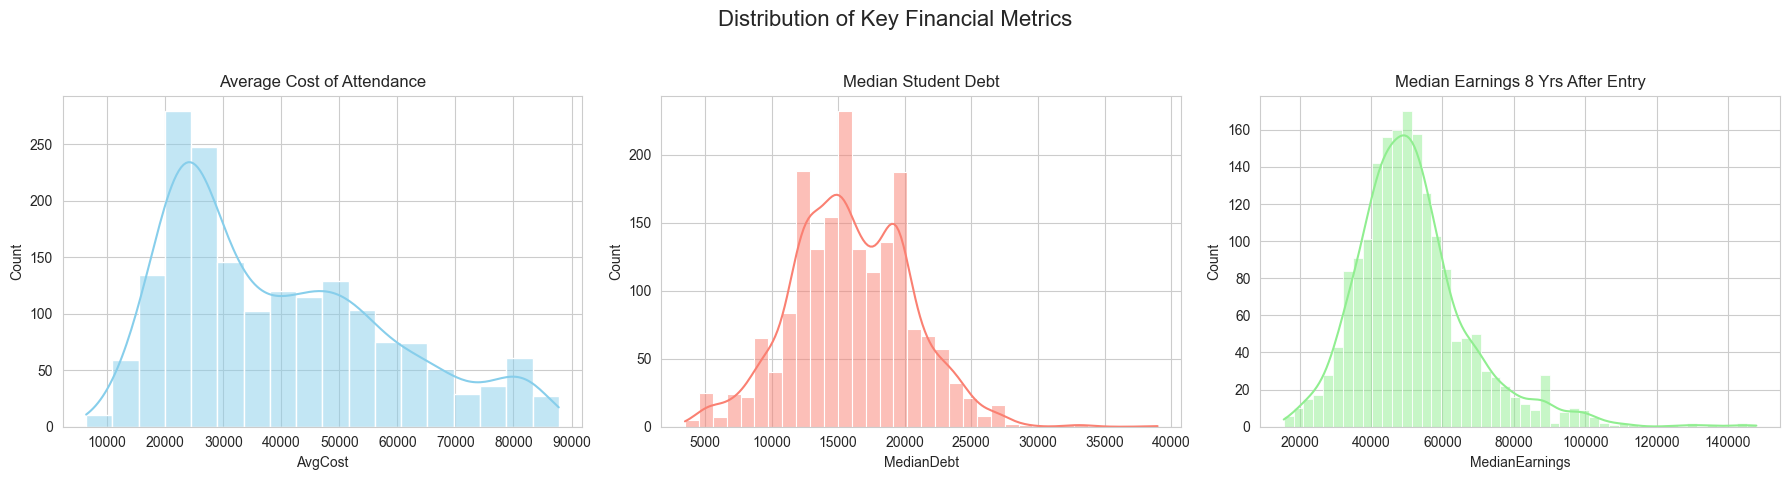

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Visualize the distributions of the key numerical features (for df_bachelors)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Distribution of Key Financial Metrics', fontsize=16)

    sns.histplot(df_bachelors['AvgCost'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Average Cost of Attendance')

    sns.histplot(df_bachelors['MedianDebt'], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Median Student Debt')

    sns.histplot(df_bachelors['MedianEarnings'], kde=True, ax=axes[2], color='lightgreen')
    axes[2].set_title('Median Earnings 8 Yrs After Entry')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



Pairwise relationships between features:


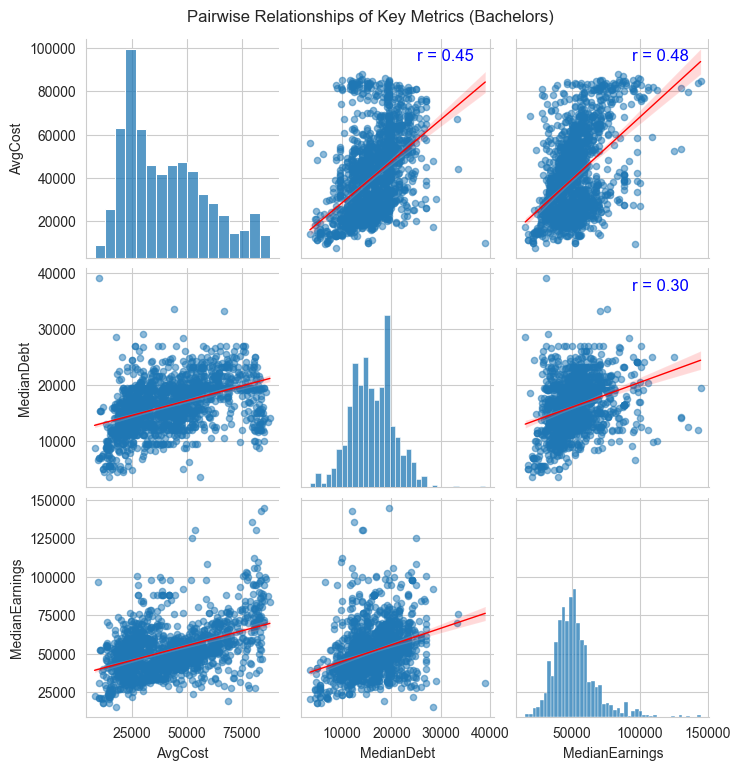

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Visualize the relationship between features using a pairplot (for df_bachelors)
    print("\nPairwise relationships between features:")

    # Calculate correlation matrix for the selected features
    corr = df_bachelors[['AvgCost', 'MedianDebt', 'MedianEarnings']].corr().round(2)

    # Annotated pairplot with correlation coefficients
    import itertools
    g = sns.pairplot(
        df_bachelors[['AvgCost', 'MedianDebt', 'MedianEarnings']].dropna(),
        kind='reg',
        plot_kws={'line_kws': {'color': 'red', 'lw': 1}, 'scatter_kws': {'alpha': 0.5, 's': 20}}
    )
    # Add correlation coefficients to the upper triangle
    for i, j in itertools.combinations(range(3), 2):
        ax = g.axes[i, j]
        feature_x = g.x_vars[j]
        feature_y = g.y_vars[i]
        r = corr.loc[feature_x, feature_y]
        ax.annotate(f"r = {r:.2f}", (0.6, 0.9), xycoords='axes fraction', fontsize=12, color='blue')

    plt.suptitle('Pairwise Relationships of Key Metrics (Bachelors)', y=1.02)
    plt.show()

## 3. Feature Selection & Preprocessing

Now, we prepare the data for the clustering algorithm. This involves:
1. Selecting our final features for clustering.
2. Converting columns to numeric types, forcing errors.
3. Handling missing values.
4. Scaling the features so they are on a comparable scale.

In [7]:
df_processed = df_bachelors.dropna(subset=['AvgCost', 'MedianDebt', 'MedianEarnings']).copy()
df_processed.drop(columns=['PredominantDegree'], inplace=True)

print(f"Original number of institutions: {len(df_bachelors)}")
print(f"Number of institutions after dropping missing values: {len(df_processed)}")
print(f"Percentage of data kept: {len(df_processed) / len(df_bachelors) * 100:.2f}%")

# Select the final features for clustering
features_for_clustering = ['AvgCost', 'MedianDebt', 'MedianEarnings']
X = df_processed[features_for_clustering]

# Standardize the features
# K-Means is distance-based, so it's crucial that all features are on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData has been preprocessed and is ready for clustering.")
print(f"Shape of scaled data: {X_scaled.shape}")


Original number of institutions: 1983
Number of institutions after dropping missing values: 1671
Percentage of data kept: 84.27%

Data has been preprocessed and is ready for clustering.
Shape of scaled data: (1671, 3)


## 4. K-Means Clustering & Model Selection

We will now apply the K-Means algorithm. A key part of using K-Means is choosing the right number of clusters (`k`). We'll use the Silhouette Score to help us make this decision.

We'll test a range of k values and calculate the silhouette score for each.
A higher silhouette score indicates better-defined clusters.

For k=2, Silhouette Score: 0.3671, Inertia: 3028.64
For k=3, Silhouette Score: 0.3327, Inertia: 2358.49
For k=4, Silhouette Score: 0.3036, Inertia: 2157.87
For k=5, Silhouette Score: 0.2619, Inertia: 1769.48
For k=6, Silhouette Score: 0.2451, Inertia: 1645.19
For k=7, Silhouette Score: 0.2865, Inertia: 1445.94
For k=8, Silhouette Score: 0.2815, Inertia: 1292.30
For k=9, Silhouette Score: 0.2796, Inertia: 1214.86
For k=10, Silhouette Score: 0.2644, Inertia: 1107.17
For k=11, Silhouette Score: 0.2735, Inertia: 1026.47
For k=12, Silhouette Score: 0.2745, Inertia: 965.40
For k=13, Silhouette Score: 0.2766, Inertia: 907.67
For k=14, Silhouette Score: 0.2741, Inertia: 869.08
For k=15, Silhouette Score: 0.2767, Inertia: 829.32


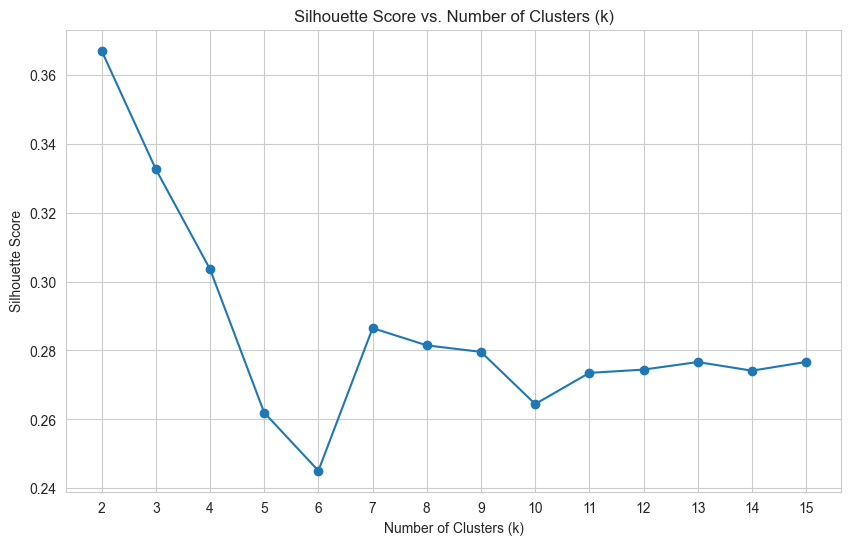


Based on the silhouette score, the optimal number of clusters is: 2

We will proceed with k=4 to provide more meaningful groupings.


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    k_range = range(2, 16) # Test k from 2 to 15
    silhouette_scores = []
    inertia_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        
        # Also store inertia (sum of squared distances to closest centroid)
        inertia_scores.append(kmeans.inertia_)
        print(f"For k={k}, Silhouette Score: {score:.4f}, Inertia: {kmeans.inertia_:.2f}")

    # Plot the Silhouette Scores to find the optimal k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    # The "best" k is often the one with the highest silhouette score.
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nBased on the silhouette score, the optimal number of clusters is: {optimal_k}")
    chosen_k = 4
    print(f"\nWe will proceed with k={chosen_k} to provide more meaningful groupings.")


## 5. Cluster Analysis & Profiling

Now that we've chosen an `k`, we'll run K-Means one last time and analyze the resulting clusters.


Cluster Profiles (mean values for each feature):


,AvgCost,MedianDebt,MedianEarnings,Count
Cluster,,,,
0,27090.80,12905.95,44668.08,789
1,63073.58,21380.19,71201.03,204
2,45573.06,18931.40,50252.84,604
3,78178.80,13902.82,83228.88,74


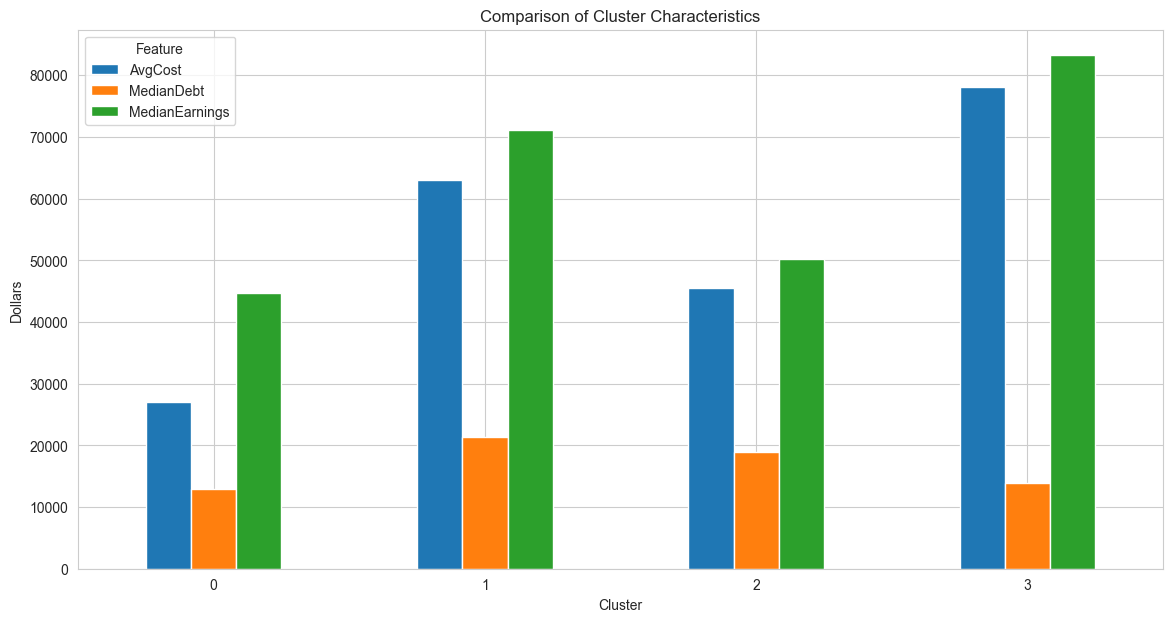


Pairplot colored by cluster label:


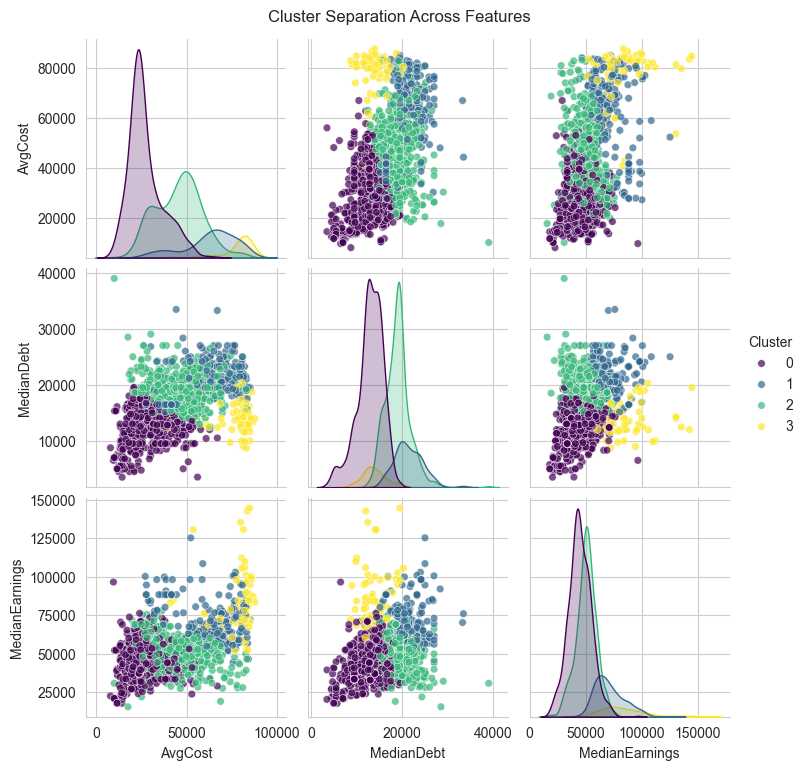

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Run K-Means with the optimal 
    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
    df_processed['Cluster'] = kmeans_final.fit_predict(X_scaled)

    # Get the centroids from the fitted KMeans model
    centroids = kmeans_final.cluster_centers_

    # Calculate distances from each school to each centroid
    distances = cdist(X_scaled, centroids)

    # For each cluster, find the index of the closest school
    closest_indices = distances.argmin(axis=0)

    # Analyze the characteristics of each cluster by calculating the mean of our features.
    cluster_profile = df_processed.groupby('Cluster')[features_for_clustering].mean().round(2)

    # Also count the number of institutions in each cluster
    cluster_profile['Count'] = df_processed['Cluster'].value_counts()

    print("\nCluster Profiles (mean values for each feature):")
    display(cluster_profile)

    # Visualize the cluster profiles to easily compare them
    cluster_profile.drop('Count', axis=1).plot(kind='bar', figsize=(14, 7))
    plt.title('Comparison of Cluster Characteristics')
    plt.ylabel('Dollars')
    plt.xticks(rotation=0)
    plt.legend(title='Feature')
    plt.show()

    # Create a pairplot colored by cluster to see the separation in multi-dimensional space
    print("\nPairplot colored by cluster label:")
    sns.pairplot(df_processed, hue='Cluster', vars=features_for_clustering, palette='viridis', plot_kws={'alpha': 0.7, 's': 30})
    plt.suptitle('Cluster Separation Across Features', y=1.02)
    plt.show()
    

In [10]:
# Median admission and graduation rate, and count per cluster
cluster_medians = df_processed.groupby('Cluster')[['AvgCost', 'MedianDebt', 'MedianEarnings', 'AdmissionRate', 'GraduationRate', 'UndergradEnrollment']].median()
cluster_counts = df_processed['Cluster'].value_counts().sort_index()
cluster_medians['Count'] = cluster_counts

print("Median Admission and Graduation Rate, and Count per Cluster:")
display(cluster_medians)

print('Top 5 schools closest to each cluster centroid:')
for cluster_num in range(kmeans_final.n_clusters):
    # Get indices of the 5 closest schools to this centroid
    closest_indices = np.argsort(distances[:, cluster_num])[:5]
    print(f'\nCluster {cluster_num}:')
    display(df_processed.iloc[closest_indices].head())

Median Admission and Graduation Rate, and Count per Cluster:


,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,GraduationRate,UndergradEnrollment,Count
Cluster,,,,,,,
0,24580.0,13000.0,44013.0,0.81105,0.46375,2573.0,789
1,65107.5,21100.0,68772.5,0.72560,0.75300,2417.0,204
2,46877.0,19000.0,50575.5,0.77800,0.59535,1347.0,604
3,81418.0,13572.0,79301.0,0.12965,0.91825,2957.5,74


Top 5 schools closest to each cluster centroid:

Cluster 0:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
2549,University of Central Oklahoma,25913.0,13000.0,44951.0,Public,0.8176,0.3750,10132.0,0
2669,Central Penn College,28251.0,13035.0,44033.0,Private For-profit,0.2593,0.3889,721.0,0
913,National Louis University,25350.0,12500.0,44485.0,Private Nonprofit,0.9312,0.3687,4100.0,0
120,Central Baptist College,27468.0,12876.0,42350.0,Private Nonprofit,0.4636,0.3529,477.0,0
2600,Eastern Oregon University,24602.0,13500.0,45983.0,Public,0.9876,0.3662,2201.0,0



Cluster 1:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
2079,Marist College,63898.0,21500.0,70306.0,Private Nonprofit,0.6471,0.7984,5039.0,1
2208,Wagner College,63007.0,21000.0,69365.0,Private Nonprofit,0.8346,0.6814,1579.0,1
1788,Creighton University,61046.0,21500.0,69364.0,Private Nonprofit,0.7231,0.8052,4231.0,1
3462,Marquette University,63233.0,20500.0,71388.0,Private Nonprofit,0.8744,0.8006,7238.0,1
969,Butler University,64503.0,22238.0,71943.0,Private Nonprofit,0.8587,0.8015,4383.0,1



Cluster 2:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
1017,University of Saint Francis-Fort Wayne,45228.0,18750.0,50591.0,Private Nonprofit,0.9756,0.6067,1599.0,2
2719,La Roche University,45623.0,19470.0,50414.0,Private Nonprofit,0.7761,0.5766,786.0,2
3165,St. Mary's University,46368.0,19500.0,49928.0,Private Nonprofit,0.8895,0.5879,1911.0,2
760,Morehouse College,47347.0,18500.0,48541.0,Private Nonprofit,0.5139,0.5267,2736.0,2
723,Brenau University,45931.0,18425.0,48236.0,Private Nonprofit,0.8696,0.3536,981.0,2



Cluster 3:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
2722,Lafayette College,78854.0,14000.0,84452.0,Private Nonprofit,0.3147,0.8805,2746.0,3
1752,Washington University in St Louis,83476.0,15000.0,81347.0,Private Nonprofit,0.1196,0.9445,7897.0,3
3046,Vanderbilt University,84412.0,12913.0,84542.0,Private Nonprofit,0.0628,0.9269,7143.0,3
577,Georgetown University,84696.0,13500.0,88766.0,Private Nonprofit,0.1308,0.9430,7462.0,3
1274,Bowdoin College,80390.0,12000.0,79520.0,Private Nonprofit,0.0802,0.9560,1846.0,3


In [11]:

# Percentage of each control type per cluster
control_type_pct = (
    df_processed.groupby('Cluster')['ControlType']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
).round(1)

print("\nPercentage of Each Control Type per Cluster:")
display(control_type_pct)


Percentage of Each Control Type per Cluster:


ControlType,Private For-profit,Private Nonprofit,Public
Cluster,,,
0,7.6,36.9,55.5
1,10.8,82.4,6.9
2,2.3,79.3,18.4
3,0.0,98.6,1.4


## 6. Conclusion & Interpretation



This analysis has successfully segmented the universities into four distinct groups. Rather than just a simple list, these clusters represent different "personas" or archetypes in the higher education landscape, each with its own financial profile and value proposition. This provides a more nuanced framework for students to evaluate their options beyond traditional rankings.



### **Cluster 0: Affordable Launchpads (789 Institutions)**

This is the largest and most accessible group, composed mainly of **public institutions (56%)**. They are defined by their low median cost (~\$25k) and low median debt (\$13k), which makes them an affordable entry point into higher education for many. While their median earnings (~\$44k) are modest compared to other groups, their low cost results in a solid return on investment. These schools, exemplified by:



University of Central Oklahoma, Central Penn College, National Louis University, Central Baptist College, and Eastern Oregon University



serve as crucial engines of social mobility.



### **Cluster 1: High-Cost, Good-Outcome Institutions (204 Institutions)**

This smaller group, also dominated by **private non-profits (82%)**, represents a significant financial investment. With a high median cost of ~\$65k and the highest median debt (~\$21k), these schools are expensive. However, this cost is often justified by strong earnings (~\$69k) and high graduation rates (75%). These institutions, exemplified by:



Marist College, Wagner College, Creighton University, Marquette University, and Butler University



offer a strong return but come with a higher level of financial risk due to the debt load.



### **Cluster 2: Mid-Tier Private Institutions (604 Institutions)**

This group consists primarily of **private non-profit schools (79%)**. They represent a middle ground, with moderate costs (~\$47k), moderate debt (~\$19k), and good earnings outcomes (~\$51k). With a median graduation rate of 60%, they offer a classic private college experience and solid, though not top-tier, financial returns. Institutions exemplifying this cluster include:



University of Saint Francis-Fort Wayne, La Roche University, St. Mary's University, Morehouse College, and Brenau University



offering a traditional campus experience for a higher price than public alternatives.



### **Cluster 3: Elite, High-ROI Institutions (74 Institutions)**

This is the smallest and most selective group (median admission rate of just 13%), composed almost entirely of **private non-profits (99%)**. These are the "elite" universities. Despite having the highest cost of attendance (~\$81k), they have surprisingly low median debt (~\$14k), likely due to generous financial aid packages. Critically, they produce the highest post-graduation earnings by a significant margin (~\$79k), alongside the highest graduation rates (92%). This combination makes them the highest return-on-investment group. Archetypal examples include:



Lafayette College, Washington University in St Louis, Vanderbilt University, Georgetown University, and Bowdoin College.